# Import Data

In [137]:
import numpy as np
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought/Data/"
file=directory+"Pressure/slp.mon.mean.nc"
nc=Dataset(file,'r')
pressure=nc.variables["slp"][0:816,0:48,48:112]
#pressure=nc.variables["slp"][0:816,0:28,0:28]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=CAMonthTotal.reshape((816, 1))
ORMonthTotal=ORMonthTotal.reshape((816, 1))
WCMonthTotal=WCMonthTotal.reshape((816, 1))
#CAMonthTotal=CAMonthTotal[1:816,:]
rlat=48
rlon=64
x_data=pressure.flatten()
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(816,rlat,rlon,1))
y_data=(CAMonthTotal-np.mean(CAMonthTotal))/np.std(CAMonthTotal)

In [138]:
cd '/Users/lambda/Documents/Code/Lib/TensorFlow'

/Users/lambda/Documents/Code/Lib/TensorFlow


# Set Computing Graph

### HyperParameters

In [139]:
ptraining=576
ctraining=[]
ctest=[]
#Convolution Layer Parameters
wc1=3
nc1=5
wc2=3
nc2=3
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
wfc=50
wfc2=10

### Graph

In [140]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,1])
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.001,name="W_conv1")),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.001)),
               'W_fc':tf.Variable(tf.random_normal([fl,wfc],stddev=0.001)),
               'W_fc2':tf.Variable(tf.random_normal([wfc,wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([wfc2, 1],stddev=0.001))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc':tf.Variable(tf.random_normal([wfc],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([1],stddev=0.001))}
    
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp1)

    fc = tf.reshape(pool2,[-1, fl])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc2 = tf.nn.relu(tf.matmul(fc, weights['W_fc2'])+biases['b_fc2'])
    output = tf.matmul(fc2, weights['out'])+biases['out'] 
    return output

In [141]:
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(prediction-y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
all_saver = tf.train.Saver()

# Train

In [142]:
def train_neural_network(x):
    batch=120
    epoches=200
    gtestcost=np.inf
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoches):
            for b in range(ptraining/batch):
                epoch_x=x_data[b*batch:(b+1)*batch,:,:,:]
                epoch_y=y_data[b*batch:(b+1)*batch,:]
                sess.run(optimizer, feed_dict={x: epoch_x, y: epoch_y})
                trainingcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y})
                ctraining.append(trainingcost)
            testcost=sess.run(cost, feed_dict={x: x_data[ptraining:,:,:,:], 
                                                   y: y_data[ptraining:,:]})
            print testcost
            if testcost < gtestcost:
                gtestcost=testcost
                all_saver.save(sess, 'CNN_Trained')
            ctest.append(testcost)
        result=sess.run(prediction,feed_dict={x: x_data})
        sess.close()
    return result 

In [143]:
prediction_batch=train_neural_network(x)

0.863772
0.863983
0.864203
0.86442
0.864365
0.861498
0.844057
0.783108
0.731323
0.701712
0.661402
0.636078
0.625345
0.581214
0.552439
0.532187
0.510419
0.49374
0.470271
0.434394
0.393265
0.343898
0.292042
0.256901
0.237857
0.216774
0.206054
0.200625
0.198987
0.199293
0.19851
0.19646
0.19073
0.185055
0.180048
0.177522
0.175698
0.174429
0.172579
0.170173
0.166986
0.164893
0.162811
0.162009
0.160464
0.158695
0.157654
0.155647
0.154354
0.153245
0.151793
0.152328
0.152045
0.153975
0.151949
0.152812
0.154744
0.154222
0.15563
0.154606
0.156129
0.156352
0.157168
0.159251
0.161804
0.163013
0.161997
0.16435
0.169381
0.168902
0.168168
0.17211
0.178114
0.187907
0.193683
0.191097
0.177692
0.170023
0.172507
0.196227
0.236159
0.246685
0.202312
0.170577
0.163305
0.22571
0.288876
0.190581
0.172373
0.208137
0.263948
0.175752
0.17986
0.250588
0.211163
0.184844
0.214578
0.228677
0.199327
0.201784
0.238814
0.220914
0.200501
0.214068
0.250273
0.222907
0.203205
0.224269
0.261598
0.229445
0.204264
0.218684
0.

KeyboardInterrupt: 

In [144]:
[np.min(ctest),np.min(ctraining)]

[0.15179303, 0.036963582]

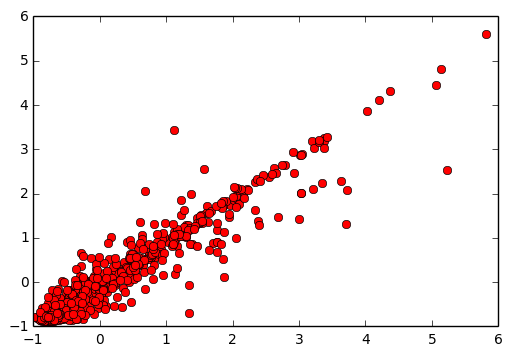

In [145]:
import matplotlib.pyplot as plt
plt.plot(prediction_batch,y_data,'ro')
plt.show()

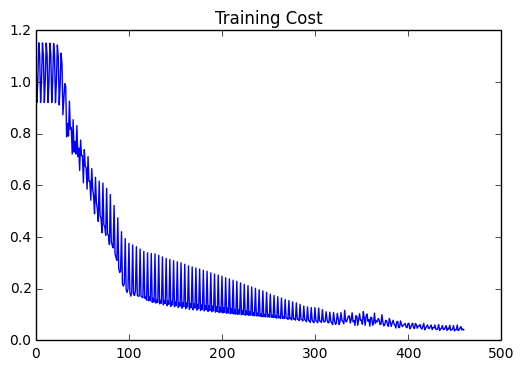

In [146]:
plt.plot(ctraining)
plt.title("Training Cost")
plt.show()

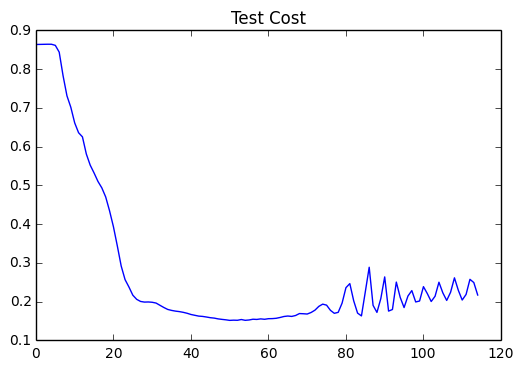

In [147]:
plt.plot(ctest)
plt.title("Test Cost")
plt.show()

# Result

In [148]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/Python/TensorFlow/CNN_Trained')
    trainingresult=sess.run(prediction,feed_dict={x:x_data[0:ptraining,:,:,:]})
    testresult=sess.run(prediction,feed_dict={x:x_data[ptraining:,:,:,:]})

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [3] rhs shape= [5]
	 [[Node: save/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@Variable_6"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_6, save/RestoreV2_18)]]

Caused by op u'save/Assign_18', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-141-0bce84f20f34>", line 4, in <module>
    all_saver = tf.train.Saver()
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 414, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [3] rhs shape= [5]
	 [[Node: save/Assign_18 = Assign[T=DT_FLOAT, _class=["loc:@Variable_6"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_6, save/RestoreV2_18)]]


In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[0:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining:,:],'ro')
plt.title("Test Result")
plt.show()

In [ ]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    range(12))

In [ ]:
map(lambda m:np.corrcoef(map(lambda x:x[0],testresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[ptraining:,:][m:ptraining:12].tolist()))[0][1],
    range(12))